# Tips Prediction of New York Yellow Taxi Customers in January 2009 

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

From all the features available, the selected features are:
1. Trip_Pickup_DateTime which is pick up time of the customer.
2. Trip_Dropoff_DateTime which is the drop off time of the customer.
3. Passenger_Count which is the number of passenger.
4. Trip_Distance which is the distance of the trip.
5. Payment_Type which is the type of payment. Either with cash or credit card.
6. Fare_amt which is the amount that customer paid.
7. Tip_Amt which is the amount of tips given by the passenger.

In [2]:
data_jan_2009 = pl.read_parquet("C:/Users/ekadw/Documents/DATA/NY_Taxi/2009/yellow_taxi/yellow_tripdata_2009-01.parquet", 
                                columns=['Trip_Pickup_DateTime','Trip_Dropoff_DateTime','Passenger_Count','Trip_Distance',
                                         'Payment_Type','Fare_Amt','Tip_Amt'])

In [3]:
len(data_jan_2009) # number of row data

14092413

In [4]:
data_jan_2009.head()

Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Payment_Type,Fare_Amt,Tip_Amt
str,str,i64,f64,str,f64,f64
"""2009-01-04 02:52:00""","""2009-01-04 03:02:00""",1,2.63,"""CASH""",8.9,0.0
"""2009-01-04 03:31:00""","""2009-01-04 03:38:00""",3,4.55,"""Credit""",12.1,2.0
"""2009-01-03 15:43:00""","""2009-01-03 15:57:00""",5,10.35,"""Credit""",23.7,4.74
"""2009-01-01 20:52:58""","""2009-01-01 21:14:00""",1,5.0,"""CREDIT""",14.9,3.05
"""2009-01-24 16:18:23""","""2009-01-24 16:24:56""",1,0.4,"""CASH""",3.7,0.0


Notice that the type of data is string for pick up and drop off time. We need to convert the type to data to date time type if we want to use the length of trip as the difference of drop off time and the pick up time. At first the name of coulmns are renamed.

In [5]:
data_jan_2009 = data_jan_2009.rename({
    "Trip_Pickup_DateTime": "trip_pickup_dateTime",
    "Trip_Dropoff_DateTime": "trip_dropoff_dateTime",
    "Passenger_Count": "passenger_count",
    "Trip_Distance": "trip_distance",
    "Payment_Type": "payment_type",
    "Fare_Amt": "fare_amt",
    "Tip_Amt": "tip_amt"
})

## Step 1: Filter data
Remove data that meaningles such as has negative number of passenger, negative trip distance, negative fare and negative tips amount. Besides that, it is assumed that maximum trip is 50 miles.

In [6]:
data_jan_2009 = data_jan_2009.filter(
    (pl.col("passenger_count") >= 0) & (pl.col("trip_distance") >= 0) & (pl.col("trip_distance") <= 50) & 
    (pl.col("fare_amt") >= 0) & (pl.col("tip_amt") >= 0)
)
len(data_jan_2009)

14092413

## Step 2: Tips record only for Customer Who Pays with Credit Card
For that reason, we need to filter data which only include the customer that pays with credit card.

In [7]:
mapping = {
    "Credit": 0,
    "CREDIT": 0,
    "CASH": 1,
    "Cash": 1,
    "No Charge": 2,
    "Dispute": 3
}

data_jan_2009 = data_jan_2009.with_columns(
    pl.col("payment_type").replace(mapping)
)

In [8]:
# Convert column of payment_type from string to integer
data_jan_2009 = data_jan_2009.with_columns(
    pl.col("payment_type").cast(pl.Int64)
)

In [9]:
# Filter data which customer only paid with credit card
data_jan_2009 = data_jan_2009.filter(
    (pl.col("payment_type") == 0) 
)

## Step 3: Remove Data that Length of Service more than 24 Hours
It is assumed that duration of each trip is not more than 24 hours.

In [10]:
# Convert pick up and drop off column from string to date time.
data_jan_2009 = data_jan_2009.with_columns([
    pl.col("trip_pickup_dateTime").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"),
    pl.col("trip_dropoff_dateTime").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"),
    pl.col("payment_type").cast(pl.Int64)
])

In [11]:
# Count duration of trip in days
data_jan_2009 = data_jan_2009.with_columns(
    ((pl.col("trip_dropoff_dateTime") - pl.col("trip_pickup_dateTime")).dt.total_seconds() / 86400)
    .cast(pl.Int64)
    .alias("duration_days")
)

In [12]:
# Only include data that duration is less than 1 day
data_jan_2009 = data_jan_2009.filter(
    (pl.col("duration_days") == 0) 
)
len(data_jan_2009)

3024652

## Step 4: Count the Duration of Each Trip
The duration of each trip is the different of drop off time and pick up time. The duration here in second.

In [13]:
data_jan_2009 = data_jan_2009.with_columns(
    ((pl.col("trip_dropoff_dateTime") - pl.col("trip_pickup_dateTime")).dt.total_seconds())
    .cast(pl.Int64)
    .alias("duration_seconds")
)

## Step 5: Delete Columns That Will not be Used Again
Column pick up time, drop off time, type of payment and duration in days are not in use again.

In [14]:
data_jan_2009 = data_jan_2009.drop(["trip_pickup_dateTime", "trip_dropoff_dateTime", "duration_days", "payment_type"])

## STEP 6: Create Category for Tips
The categories are giving tips or no tips. It will be 0 for no tips and will be 1 if tips was given.

In [15]:
data_jan_2009 = data_jan_2009.with_columns(
    pl.when(pl.col("tip_amt") <= 0.0).then(1)
     .otherwise(0)
     .alias("tip_category")
)

In [16]:
data_jan_2009 = data_jan_2009.drop(["tip_amt"])

In [17]:
data_jan_2009.head()

passenger_count,trip_distance,fare_amt,duration_seconds,tip_category
i64,f64,f64,i64,i32
3,4.55,12.1,420,0
5,10.35,23.7,840,0
1,5.0,14.9,1262,0
1,0.4,5.7,585,0
1,1.6,8.7,679,0


## Step 7: Check the Correlation Amongs Features

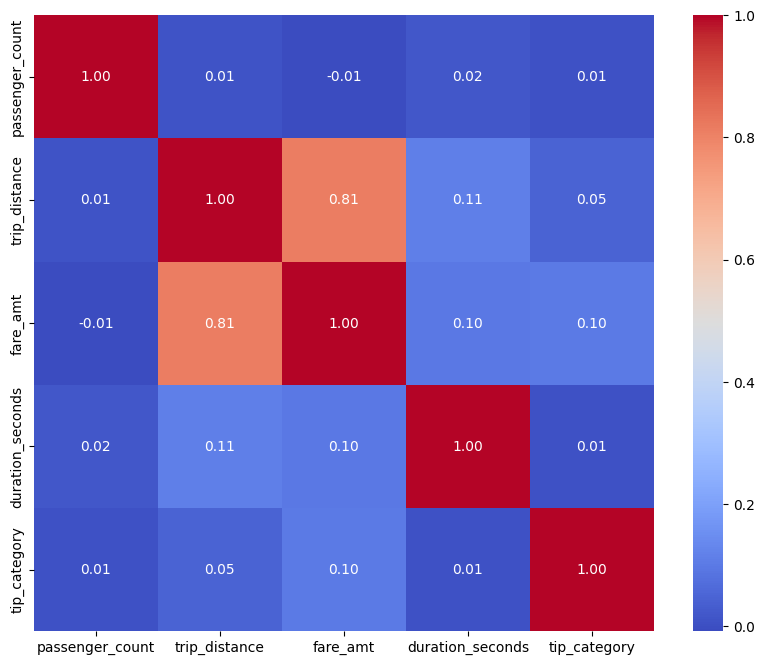

In [18]:
corr_df = data_jan_2009.select(pl.all().cast(pl.Float64)).to_pandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

There will me multicolienarity between trip distance and fare amount. This result is understandable because there will be strong correlation between trip distance and fare amount. The longer of distance, the cost will be higher. But using tree type of classification, the impact of multicollinearity can be minimized.

## Step 8: Check the Balance of Target Dataset
This step is really important because imbalance target will give the classification method a chance to predicts the majority. This bias will suffer the minority but the accuracy will be remain high.  

In [19]:
data_jan_2009["tip_category"].value_counts()

tip_category,count
i32,u32
1,92216
0,2932436


There is an imbalance dataset. The solution is by balancing the dataset with SMOTE. It will be included in the data pipeline.

## Step 9: Select Features as Predictors and Target. Then Convert to Numpy.

In [20]:
y = data_jan_2009.select('tip_category').to_numpy().ravel().astype(int)
X = data_jan_2009.drop(['tip_category']).to_numpy()


## Step 10: Split Data into Train and Test

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

## Step 11: Create Data Pipeline with Logistic Regression

In [22]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np

# Build the pipeline
pipeline_lr = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Train model
pipeline_lr.fit(X_train, y_train)

# Predictions
y_pred = pipeline_lr.predict(X_test)
y_score = pipeline_lr.predict_proba(X_test)


## Step 12: Confusion Matrix

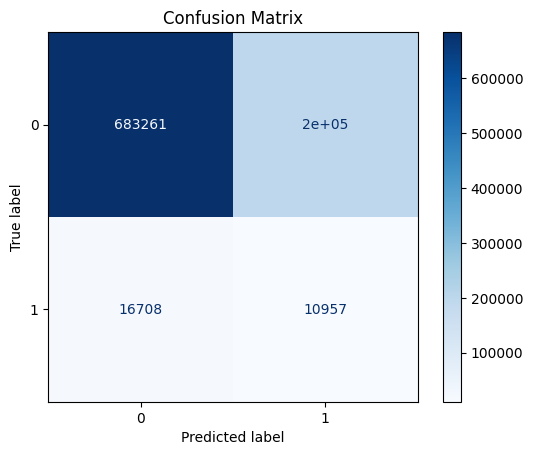

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Step 13: ROC Curve

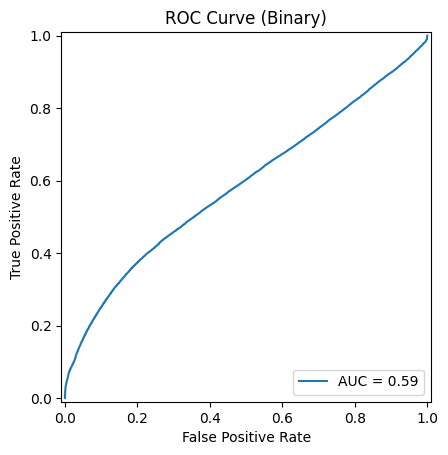

In [24]:
# ROC Curve (handles binary or multiclass automatically)
n_classes = len(np.unique(y))
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title("ROC Curve (Binary)")
    plt.show()
else:
    # For multiclass: one-vs-rest ROC curves
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass One-vs-Rest)")
    plt.legend()
    plt.show()